# Load

In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import warnings

warnings.filterwarnings('ignore')

# --- Configuration ---
SEQUENCE_LENGTH = 30
#crit_thresh = 3.277077
#warn_thresh = 1.464656
#crit_thresh = 1.194757
#warn_thresh = 0.807623
crit_thresh = 18.622056
warn_thresh = 4.605824





numerical_cols = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']
label_order = ['Critical', 'Warning', 'Normal']
PREDICTION_HORIZON = 0
palette = {'Critical': 'red', 'Warning': 'orange', 'Normal': 'green'}

In [2]:
# --- Utility Functions ---
def load_resources(scaler_path, model_path):
    try:
        scaler = joblib.load(scaler_path)
        model = load_model(model_path, compile=False)
        print("✅ Resources loaded.")
        return scaler, model
    except Exception as e:
        raise RuntimeError(f"❌ Error loading resources: {e}")


def preprocess_data(file_paths, numerical_cols):
    dfs = [pd.read_csv(p) for p in file_paths]
    df = pd.concat(dfs, ignore_index=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Handle missing or incorrect labels
    df['label'] = df.get('label', 'Normal')
    df['label'] = df['label'].fillna('Normal').str.capitalize()
    df['label'] = df['label'].replace({'Critical': 'Critical', 'Warning': 'Warning', 'Normal': 'Normal'})

    # Check numerical columns
    missing = [c for c in numerical_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing numerical columns: {missing}")
    return df


def scale_features(df, scaler, numerical_cols):
    scaled = scaler.transform(df[numerical_cols])
    for i, col in enumerate(numerical_cols):
        df[f'scaled_{col}'] = scaled[:, i]
    return df


def create_sequences_by_device(df, seq_len, numerical_cols, dev_ids=None, return_index=False):
    sequences, dev_list, timestamps, indices = [], [], [], []

    for dev_id, group in df.groupby('devID'):
        if dev_ids and dev_id not in dev_ids:
            continue
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        ts = group['timestamp'].values
        idx = group.index.values

        for i in range(len(values) - seq_len + 1):
            sequences.append(values[i:i + seq_len])
            dev_list.append(dev_id)
            timestamps.append(ts[i + seq_len - 1])
            if return_index:
                indices.append(idx[i + seq_len - 1])

    return (np.array(sequences), dev_list, timestamps, indices) if return_index else (np.array(sequences), dev_list, timestamps)


def classify_risk(score):
    if score > crit_thresh:
        return 'Critical'
    if score > warn_thresh:
        return 'Warning'
    return 'Normal'


def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X), pca


def plot_pca(X_pca, labels, title):
    plt.figure(figsize=(8, 6))
    for lbl in np.unique(labels):
        idx = labels == lbl
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=lbl, color=palette.get(lbl, 'gray'))
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [3]:
# --- Load model & preprocess training data ---
scaler, model = load_resources('scaler_fit.save', 'lstm_autoencoder_model_fit.h5')

df_raw = preprocess_data(['./../../data/dev101_resample1T.csv'], numerical_cols)
df_raw.drop(columns=["label"], inplace=True)
df_scaled = scale_features(df_raw.copy(), scaler, numerical_cols)

X_seq, dev_ids, seq_times, orig_idxs = create_sequences_by_device(df_scaled, SEQUENCE_LENGTH, numerical_cols, return_index=True)
if X_seq.size == 0:
    raise RuntimeError("❌ No sequences formed.")


✅ Resources loaded.


# PCA

🔍 Mean reconstruction error per sensor:
 soil_mean    0.003109
rain_mean    1.705755
temp_mean    0.005485
humi_mean    0.009452
geo_mean     0.097008
dtype: float64

📊 PCA Loadings:
                 PC1       PC2
soil_mean  0.000294  0.025298
rain_mean  0.999958 -0.009206
temp_mean  0.000107  0.008278
humi_mean  0.000065  0.002621
geo_mean   0.009201  0.999600


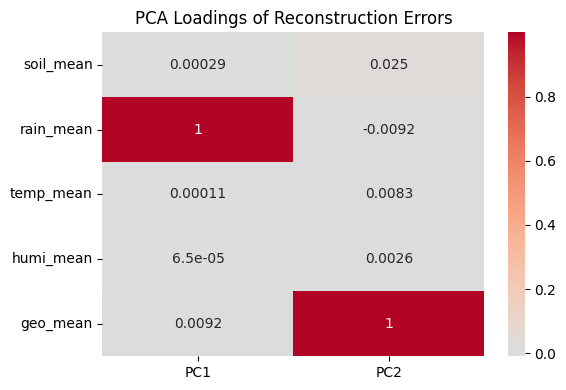

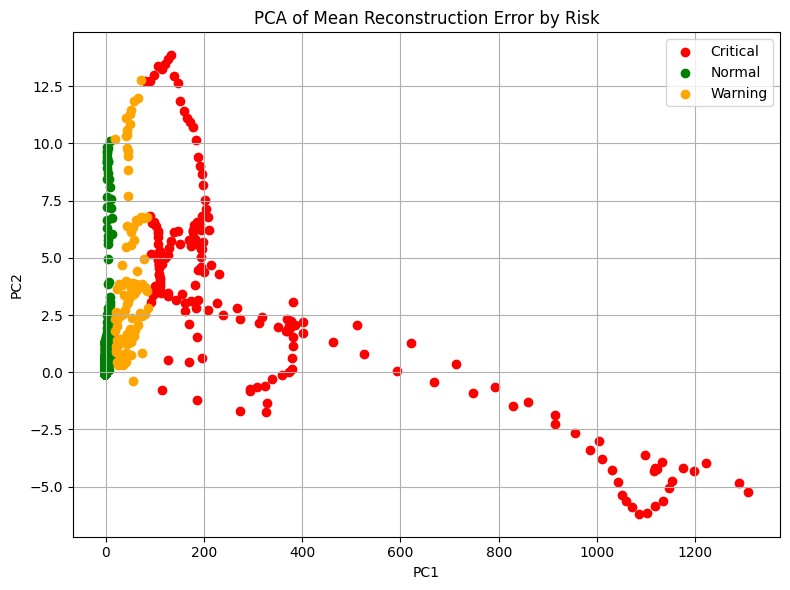

In [4]:
# --- Reconstruction ---
X_rec = model.predict(X_seq, verbose=0)
errors_full = np.square(X_seq - X_rec)
errors = np.mean(errors_full, axis=(1, 2))

df_seq = pd.DataFrame({
    'original_index': orig_idxs,
    'timestamp': seq_times,
    'devID': dev_ids,
    'anomaly_score': errors
})

df_seq['predicted_risk'] = df_seq['anomaly_score'].apply(classify_risk)


# --- Mean Reconstruction Error Per Sensor ---
mean_errors_per_sensor = np.mean(errors_full, axis=1)
df_mean_sensors = pd.DataFrame(mean_errors_per_sensor, columns=numerical_cols)
sensor_means = df_mean_sensors.mean()
print("🔍 Mean reconstruction error per sensor:\n", sensor_means.round(6))

# --- PCA ---
X_pca_sensor, pca_model_sensor = apply_pca(mean_errors_per_sensor)
loadings_sensor = pd.DataFrame(
    pca_model_sensor.components_.T,
    index=numerical_cols,
    columns=[f'PC{i+1}' for i in range(pca_model_sensor.n_components_)]
)
print("\n📊 PCA Loadings:\n", loadings_sensor.round(6))

# --- Heatmap PCA Loadings ---
plt.figure(figsize=(6, 4))
sns.heatmap(loadings_sensor, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings of Reconstruction Errors")
plt.tight_layout()
plt.show()

# --- PCA Plot ---
plot_pca(X_pca_sensor, np.array(df_seq['predicted_risk']), 'PCA of Mean Reconstruction Error by Risk')

In [5]:
crit_thresh

18.622056

In [6]:
warn_thresh

4.605824

In [7]:
# --- Combine with raw data for KDE & Boxplot ---
data_val = df_raw.loc[df_seq['original_index']].copy()
data_val['predicted_risk'] = df_seq['predicted_risk'].values
data_val['anomaly_score'] = df_seq['anomaly_score'].values
data_val.dropna(inplace=True)

# R2 and MSE

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ใช้ X_seq เป็นข้อมูล train
n_features = len(numerical_cols)
X_pred = model.predict(X_seq)

# แปลงเป็น 2D สำหรับคำนวณ (samples*time steps, features)
X_seq_flat = X_seq.reshape(-1, n_features)
X_pred_flat = X_pred.reshape(-1, n_features)
# คำนวณ MSE และ R²
mse_value = mean_squared_error(X_seq_flat, X_pred_flat)
r2_value = r2_score(X_seq_flat, X_pred_flat)

print(f"MSE: {mse_value:.6f}")
print(f"R²: {r2_value:.6f}")


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step
MSE: 0.364162
R²: 0.931703


# Describe

In [9]:
for risk in ['Critical', 'Warning', 'Normal']:
    group = data_val[data_val['predicted_risk'] == risk]
    print(f"Summary statistics for {risk} group:")
    print(group[numerical_cols].describe())
    print()


Summary statistics for Critical group:
        soil_mean   rain_mean   temp_mean   humi_mean    geo_mean
count  179.000000  179.000000  179.000000  179.000000  179.000000
mean    58.117114   13.361460   26.785710   81.265636   16.602663
std      4.182438   10.108215    0.529713    0.671844    5.287972
min     52.299999    0.000000   25.710975   80.111429    6.020723
25%     54.900002    3.352800   26.400855   80.787023   13.426274
50%     56.299999   15.646400   26.806210   81.291907   17.008964
75%     62.780000   18.160999   27.259099   81.751013   20.069227
max     64.699997   40.513000   27.739223   84.416066   28.685487

Summary statistics for Warning group:
        soil_mean   rain_mean   temp_mean   humi_mean    geo_mean
count  104.000000  104.000000  104.000000  104.000000  104.000000
mean    58.671538   10.010893   27.070094   81.202991   17.401180
std      5.352877    8.528489    0.571372    0.624771    5.386065
min     51.760001    0.000000   25.963989   80.085298    3.32961

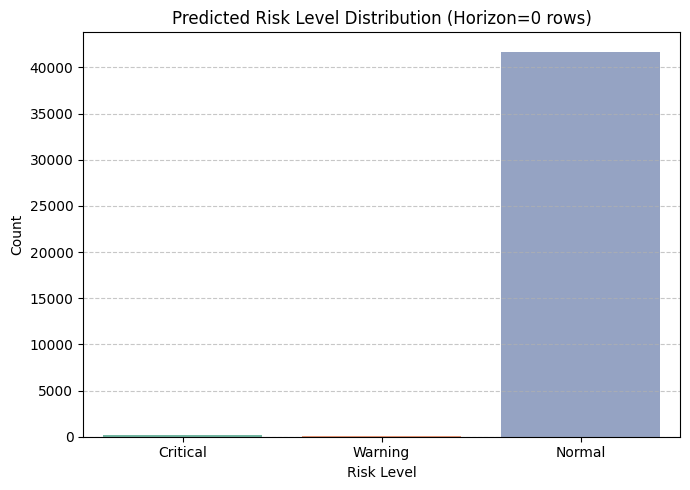

In [10]:
# Plot 1: Predicted Risk Level Distribution
plt.figure(figsize=(7, 5))
sns.countplot(data=data_val, x='predicted_risk', order=label_order, palette='Set2')
plt.title(f'Predicted Risk Level Distribution (Horizon={PREDICTION_HORIZON} rows)')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Distribution of Anomaly Scores

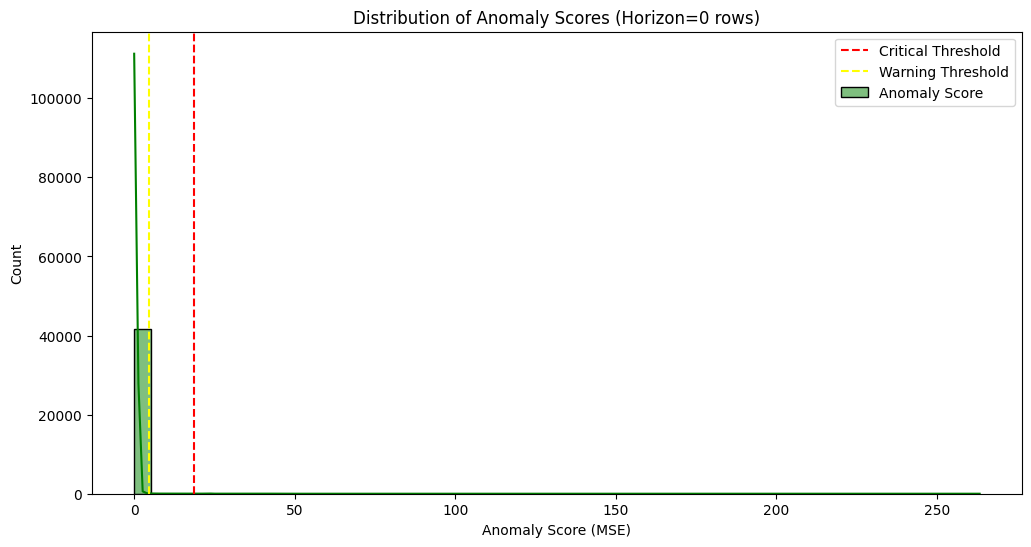

In [11]:
# Plot 2: Anomaly Score Distribution with Thresholds
plt.figure(figsize=(12, 6))
sns.histplot(data_val['anomaly_score'], bins=50, kde=True, color='green', label='Anomaly Score')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title(f'Distribution of Anomaly Scores (Horizon={PREDICTION_HORIZON} rows)')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.show()

# histogram

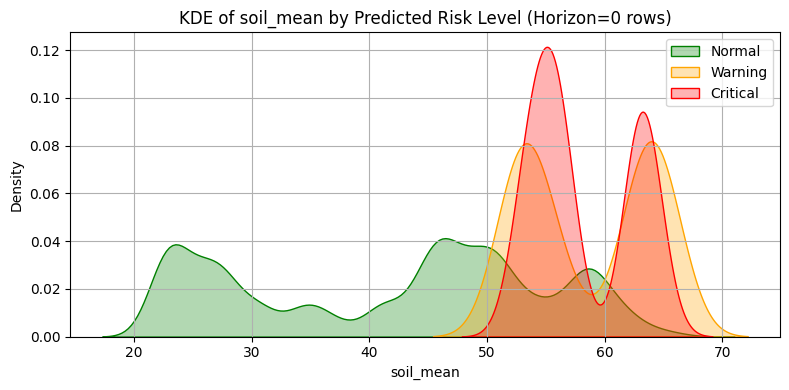

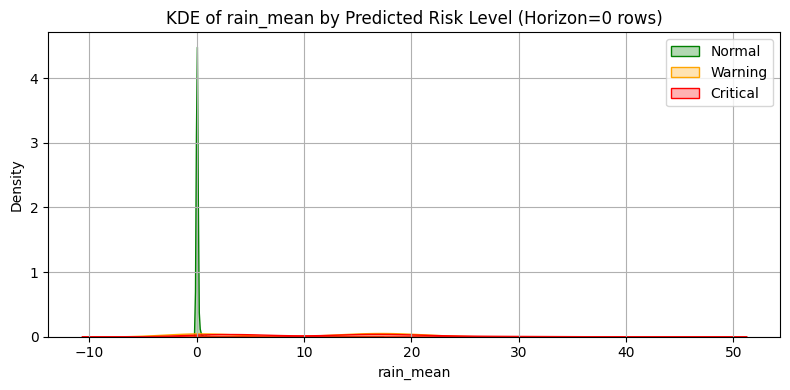

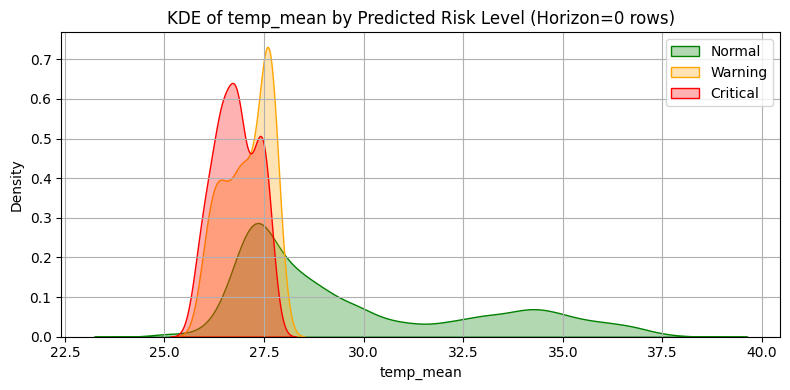

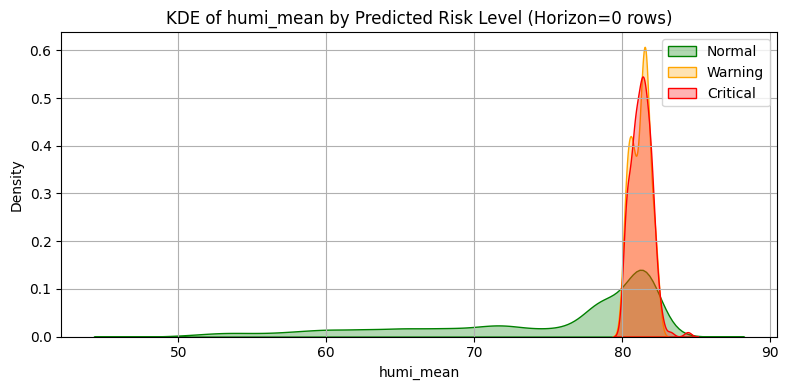

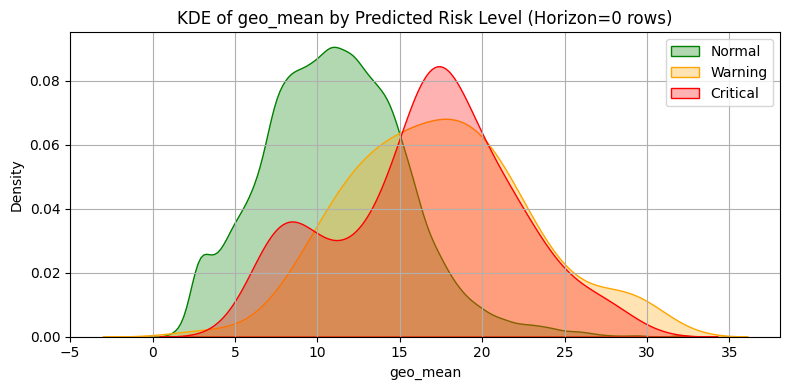

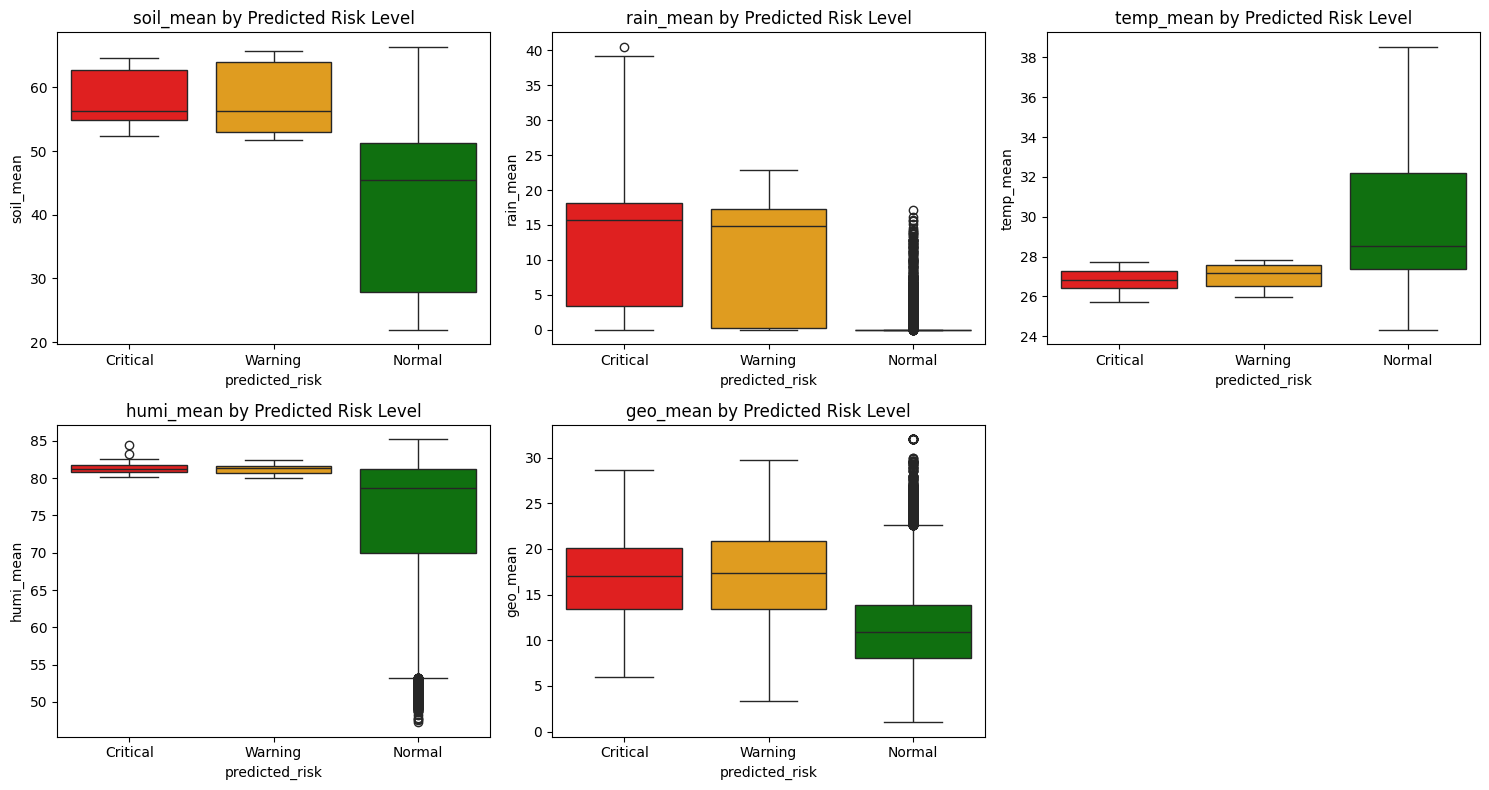

In [12]:
palette = {'Critical': 'red', 'Warning': 'orange', 'Normal': 'green'}

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data_val[data_val['predicted_risk'] == 'Normal'][col], label='Normal', color=palette['Normal'], fill=True, alpha=0.3)
    sns.kdeplot(data_val[data_val['predicted_risk'] == 'Warning'][col], label='Warning', color=palette['Warning'], fill=True, alpha=0.3)
    sns.kdeplot(data_val[data_val['predicted_risk'] == 'Critical'][col], label='Critical', color=palette['Critical'], fill=True, alpha=0.3)
    plt.title(f"KDE of {col} by Predicted Risk Level (Horizon={PREDICTION_HORIZON} rows)")
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Box plots for numerical columns by Predicted Risk
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=data_val,
        order=label_order,
        palette=palette
    )
    plt.title(f'{col} by Predicted Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [13]:
data_val['timestamp'].min()

Timestamp('2025-05-02 12:11:00')

In [14]:
data_val['timestamp'].max()

Timestamp('2025-07-22 19:39:00')

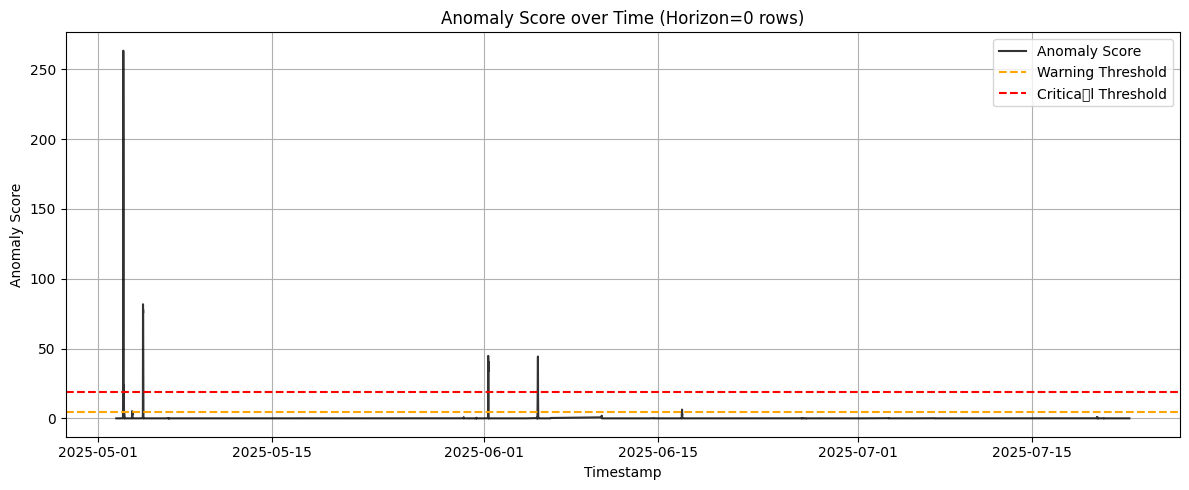

In [15]:
# --- Anomaly Score over Time ---
# Use df_proc for plotting anomaly scores
if 'timestamp' in data_val.columns:
    df_sorted_for_plot = data_val.sort_values('timestamp')
    plt.figure(figsize=(12, 5))
    plt.plot(df_sorted_for_plot['timestamp'], df_sorted_for_plot['anomaly_score'], color='black', label='Anomaly Score', alpha=0.8)
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning Threshold')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Criticaหl Threshold')
    plt.title(f'Anomaly Score over Time (Horizon={PREDICTION_HORIZON} rows)')
    plt.xlabel('Timestamp')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


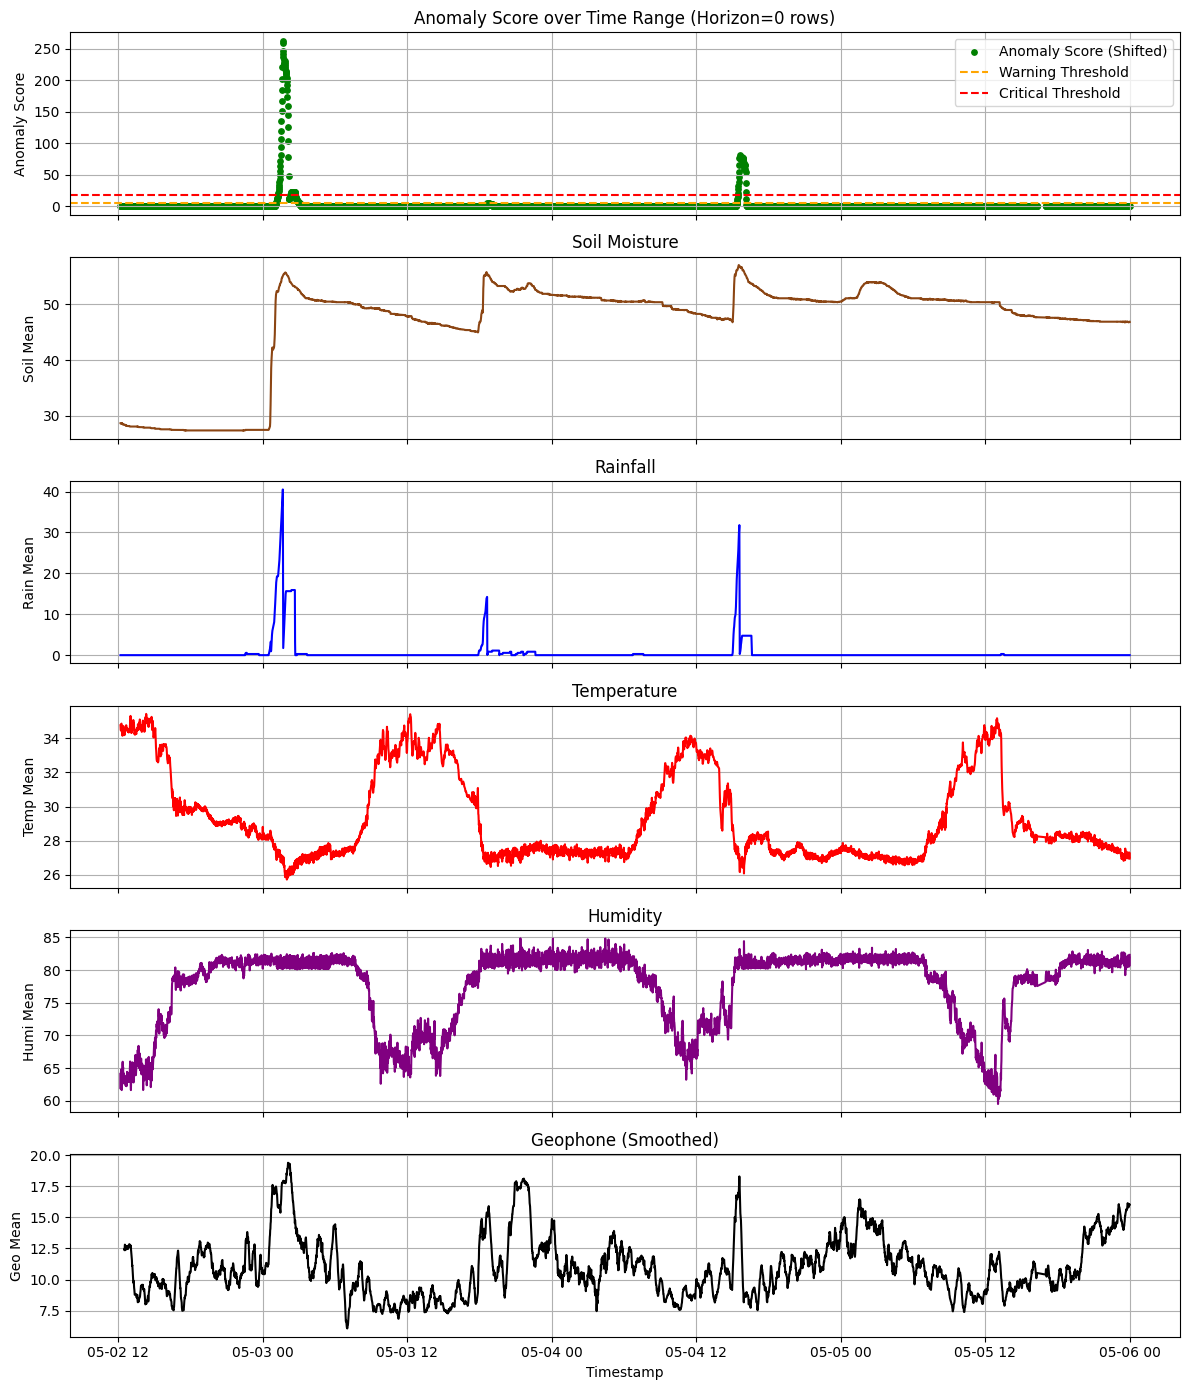

In [21]:
# --- Detailed Time Series Plot for a Specific Range ---
df_dev_time_series = data_val.set_index('timestamp').sort_index()
# Define a specific date range (adjust as per your data's timestamps)
time_series_start = "2025-05-02 0:00:00"
time_series_end = "2025-05-06 0:00:00"
df_range = df_dev_time_series.loc[time_series_start:time_series_end].copy()
if not df_range.empty:
    fig, axs = plt.subplots(6, 1, figsize=(12, 14), sharex=True) # Increased height for better visibility
    # Plot 1: Anomaly Score
    axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15, label='Anomaly Score (Shifted)')
    axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning Threshold')
    axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical Threshold')
    axs[0].set_ylabel("Anomaly Score")
    axs[0].set_title(f"Anomaly Score over Time Range (Horizon={PREDICTION_HORIZON} rows)")
    axs[0].legend(loc='upper right')
    axs[0].grid(True) 
    # Plot 2-5: Numerical columns
    axs[1].plot(df_range.index, df_range['soil_mean'], color='saddlebrown')
    axs[1].set_ylabel("Soil Mean")
    axs[1].set_title("Soil Moisture")
    axs[1].grid(True)
    axs[2].plot(df_range.index, df_range['rain_mean'], color='blue')
    axs[2].set_ylabel("Rain Mean")
    axs[2].set_title("Rainfall")
    axs[2].grid(True)
    axs[3].plot(df_range.index, df_range['temp_mean'], color='red')
    axs[3].set_ylabel("Temp Mean")
    axs[3].set_title("Temperature")
    axs[3].grid(True)
    axs[4].plot(df_range.index, df_range['humi_mean'], color='purple')
    axs[4].set_ylabel("Humi Mean")
    axs[4].set_title("Humidity")
    axs[4].grid(True)
    # Plot 6: Smoothed Geophone
    window_size = 20 # Adjust as needed
    smoothed_geo = df_range['geo_mean'].rolling(window=window_size).mean()
    axs[5].plot(df_range.index, smoothed_geo, color='black')
    axs[5].set_ylabel("Geo Mean")
    axs[5].set_title("Geophone (Smoothed)")
    axs[5].grid(True)
    plt.xlabel("Timestamp")
    plt.tight_layout()
    plt.show()
else:
    print(f"\nWarning: The specified date range '{time_series_start}' to '{time_series_end}' for detailed time series plot is empty. Please check your data's timestamps.")


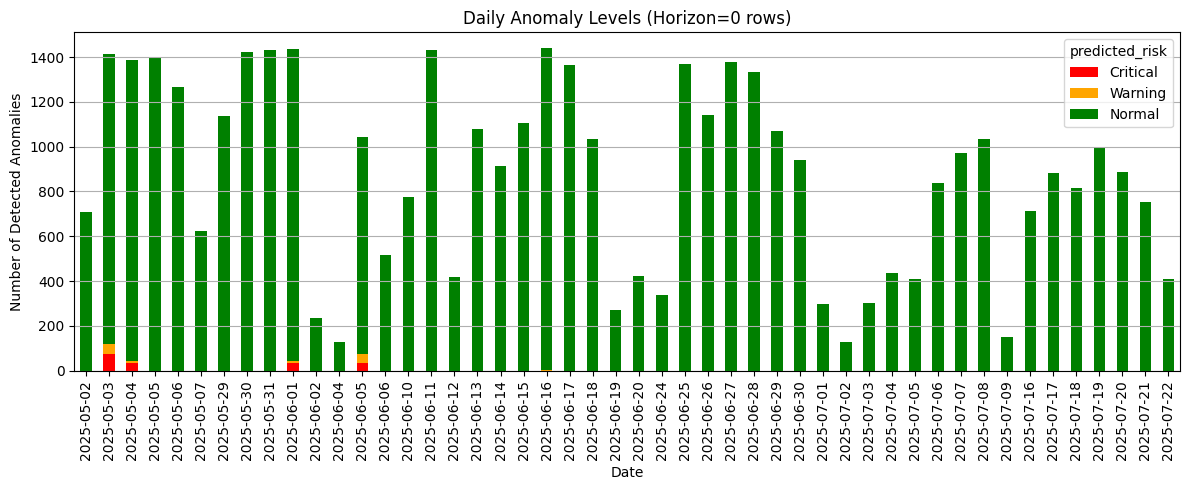

In [17]:
# --- Daily Anomaly Levels ---
df_results_daily = data_val.copy()
df_results_daily['date'] = pd.to_datetime(df_results_daily['timestamp']).dt.date
# Group by date and predicted_risk to count daily alerts
alerts_per_day = df_results_daily.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)
# Ensure all risk levels are present in columns, fill with 0 if not
for risk in label_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0
alerts_per_day = alerts_per_day[label_order] # Reorder columns as per label_order
colors_for_bars = [palette.get(risk, 'gray') for risk in label_order] # Get colors from custom_palette
alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors_for_bars)
plt.title(f"Daily Anomaly Levels (Horizon={PREDICTION_HORIZON} rows)")
plt.xlabel("Date")
plt.ylabel("Number of Detected Anomalies")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

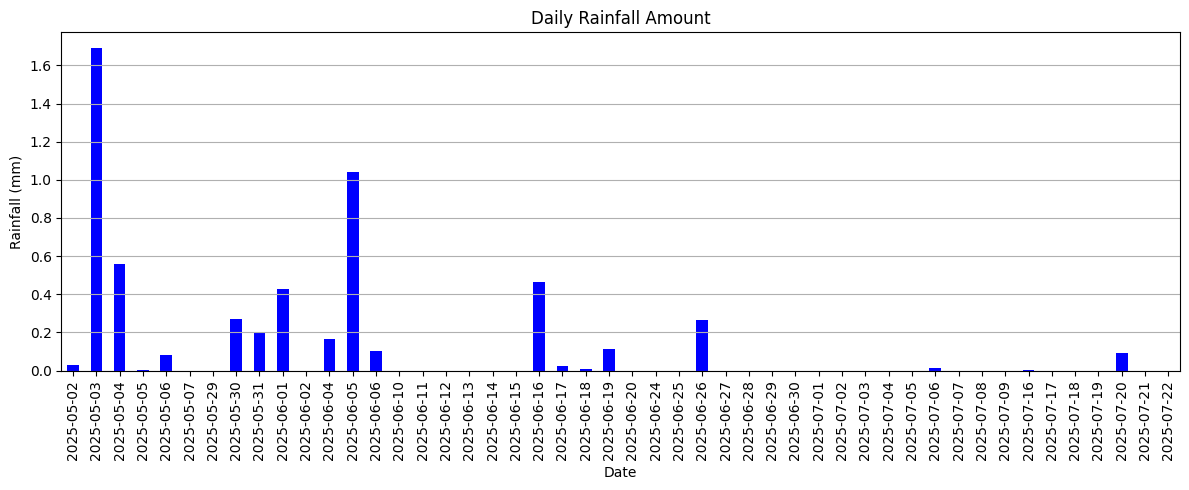

In [18]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results_daily['date'] = pd.to_datetime(df_results_daily['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results_daily.groupby('date')['rain_mean'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
data_val[data_val["predicted_risk"] == "Critical"]

,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,hour,predicted_risk,anomaly_score
815,2025-05-03 01:17:00,101,52.299999,19.669761,27.447090,80.516367,18.299879,1,Critical,19.666284
816,2025-05-03 01:18:00,101,52.520000,20.284440,27.269780,81.439537,18.306053,1,Critical,21.634242
817,2025-05-03 01:19:00,101,52.633332,20.908433,27.229280,81.080696,16.969555,1,Critical,24.037539
818,2025-05-03 01:20:00,101,52.999999,21.513800,27.058824,81.789732,16.852843,1,Critical,26.844880
819,2025-05-03 01:21:00,101,53.059999,22.072599,27.264440,80.881438,16.153303,1,Critical,30.090622
...,...,...,...,...,...,...,...,...,...,...
12754,2025-06-05 08:31:00,101,62.720000,0.000000,27.134661,82.601131,16.485987,8,Critical,24.575954
12755,2025-06-05 08:32:00,101,62.740000,0.000000,27.557106,81.140080,12.023596,8,Critical,23.197440
12756,2025-06-05 08:33:00,101,62.740000,0.000000,27.621194,81.060352,15.575575,8,Critical,21.858761
12757,2025-06-05 08:34:00,101,62.780000,0.000000,27.692226,81.056155,14.830864,8,Critical,20.652202


In [20]:
data_val[data_val["predicted_risk"] == "Warning"]

,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,hour,predicted_risk,anomaly_score
804,2025-05-03 01:06:00,101,51.760001,17.155160,27.186464,81.738614,21.021281,1,Warning,4.632011
805,2025-05-03 01:07:00,101,51.980000,17.769839,27.159763,81.357901,19.338437,1,Warning,5.707181
806,2025-05-03 01:08:00,101,52.219999,18.272759,27.116502,80.897079,17.901599,1,Warning,6.874485
807,2025-05-03 01:09:00,101,52.320000,18.663921,26.861219,82.123143,10.396506,1,Warning,8.097831
808,2025-05-03 01:10:00,101,52.400002,18.999201,27.279126,80.450468,15.728355,1,Warning,9.413843
...,...,...,...,...,...,...,...,...,...,...
12770,2025-06-05 08:47:00,101,62.720000,0.279400,27.655909,81.359047,15.148865,8,Warning,8.207683
12771,2025-06-05 08:48:00,101,62.740000,0.279400,27.783016,80.819640,20.302989,8,Warning,8.791026
12772,2025-06-05 08:49:00,101,62.740000,0.279400,27.806515,80.758603,15.992509,8,Warning,7.427905
12773,2025-06-05 08:50:00,101,62.700001,0.279400,27.837490,80.747920,14.532976,8,Warning,5.607110
